In [1]:
#first I have downloaded the GLD and USO daily prices form yahoo finance, and saved them as csv files
#we will go through all the steps to create a simple pair trading strategy between them.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johansen_test
from statsmodels.tsa.stattools import coint as cadf_test
import datetime
from statsmodels.regression.linear_model import OLS as least_sqaures_regression
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [2]:
#first we need to test wheather the two stocks cointegrate using the Johansen test
#This is how the johasen test works in statsmodels
#johansen_test(input_data, deterministic order, number_lags) 
#input_data = [df_time series 1, df_time series 2]
gold_prices = pd.read_csv("Stock_data/GLD_daily.csv")
oil_prices = pd.read_csv("Stock_data/USO_daily.csv")
gold_prices["Date"] = pd.to_datetime(gold_prices['Date'])
oil_prices["Date"] = pd.to_datetime(oil_prices['Date'])

input_data = pd.DataFrame()
input_data["GLD"] = gold_prices[gold_prices["Date"] > datetime.datetime(2007,1,1)]["Close"].reset_index(drop=True) 
input_data["USO"] = oil_prices[oil_prices["Date"] > datetime.datetime(2007,1,1)]["Close"].reset_index(drop=True) 


jres = johansen_test(input_data, 0 , 1)

trstat = jres.lr1                       # trace statistic
tsignf = jres.cvt                       # critical values
eigen_vec = jres.evec
eigen_ord = jres.ind                   

print("Eigen vectors:", eigen_vec)
print(eigen_ord)
print(trstat)
print(tsignf)


Eigen vectors: [[ 0.03903416 -0.00707638]
 [ 0.00444021  0.00514214]]
[0 1]
[7.43610603 0.95822082]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [3]:
#Lets double check these numbers with a CADF test
cadf_test(input_data["GLD"], input_data["USO"] )

(-2.272435700404821,
 0.3873847286679448,
 array([-3.89933891, -3.33774648, -3.0455719 ]))

Notice that the p value is not small enough such that we can reject the null hypothesis, there is a >10% chance of this test statistic occuring given the data, thus we have backed up our findings from the Johansen test

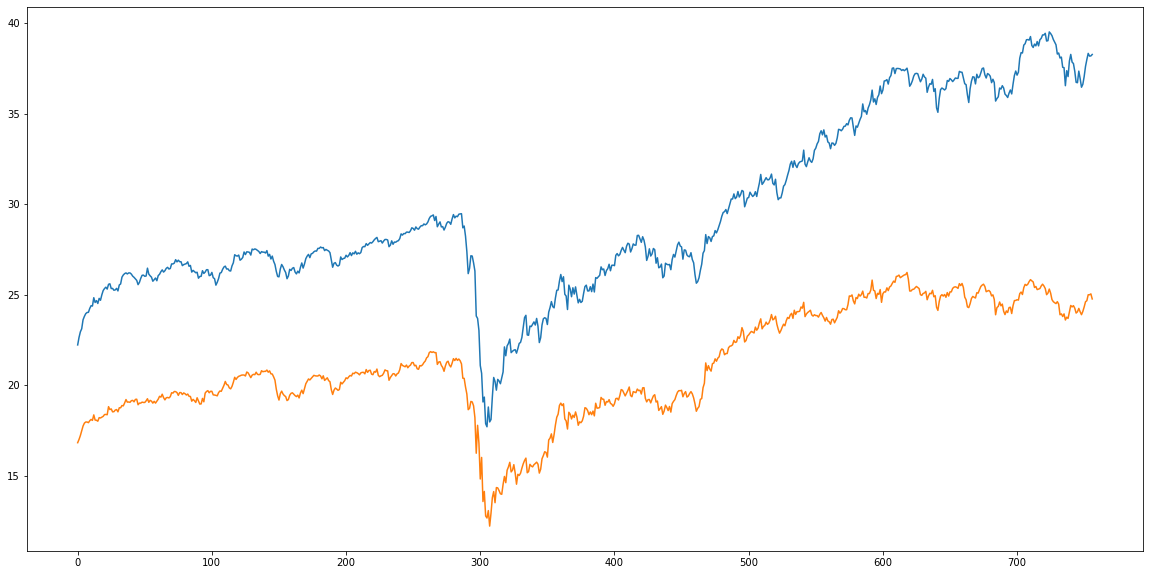

In [4]:
#Check a different combination of ETFs to see a coitegrating example
ewc = pd.read_csv("Stock_data/EWC.csv")
ewa = pd.read_csv("Stock_data/EWA.csv")
ewa["Date"] = pd.to_datetime(ewa["Date"])
ewc["Date"] = pd.to_datetime(ewc["Date"])

plt.figure(figsize=(20,10))
plt.plot(ewc["Open"])
plt.plot(ewa["Open"])
plt.show()

1.404935009410224
0.7100701951177416


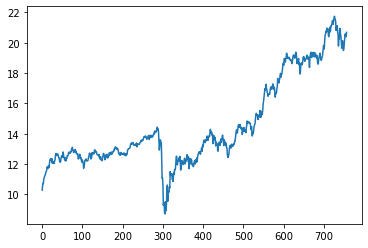

In [5]:
#find the hedge ratio with a simple least sqaures regression
model_1 = least_sqaures_regression(ewc["Open"],ewa["Open"])
model_2 = least_sqaures_regression(ewa["Open"],ewc["Open"]) #switch the dependant and independant variables
results_1 = model_1.fit()
results_2 = model_2.fit()
print(results_1.params[0])
print(results_2.params[0])


stationary_plot = pd.DataFrame()
stationary_plot["Plot"] = ewc["Open"] - results_2.params[0] * ewa["Open"]
plt.plot(stationary_plot["Plot"])


In [14]:
adfuller(stationary_plot["Plot"])

(-0.439959559222557,
 0.9032101486279716,
 7,
 749,
 {'1%': -3.439110818166223,
  '5%': -2.8654065210185795,
  '10%': -2.568828945705979},
 -143.3804208871445)

In [7]:
#let try with a direct CADF test
#you can see that the plot is not really stationary
#but we can replicate the test on the book
test_replicate = pd.DataFrame()
test_replicate["Date"] = ewa[ewa["Date"] < datetime.datetime(2020, 4,9) ]["Date"]
test_replicate["EWA"] = ewa[ewa["Date"] < datetime.datetime(2020, 4,9) ]["Open"]
test_replicate["EWC"] = ewc[ewc["Date"] < datetime.datetime(2020, 4,9) ]["Open"]

#cadf_test(ewc["Open"] , ewa["Open"],maxlag=1)
cadf_test(test_replicate["EWA"] , test_replicate["EWC"], trend='c', maxlag=1)

(-3.3621893413640067,
 0.04672706085651122,
 array([-3.93110144, -3.35535097, -3.05777203]))

0.7384474040802398
(-3.415057443589518, 0.010456149960418552, 7, 312, {'1%': -3.4514843502727306, '5%': -2.8708485956333556, '10%': -2.571729625657462}, -99.93024037307725)


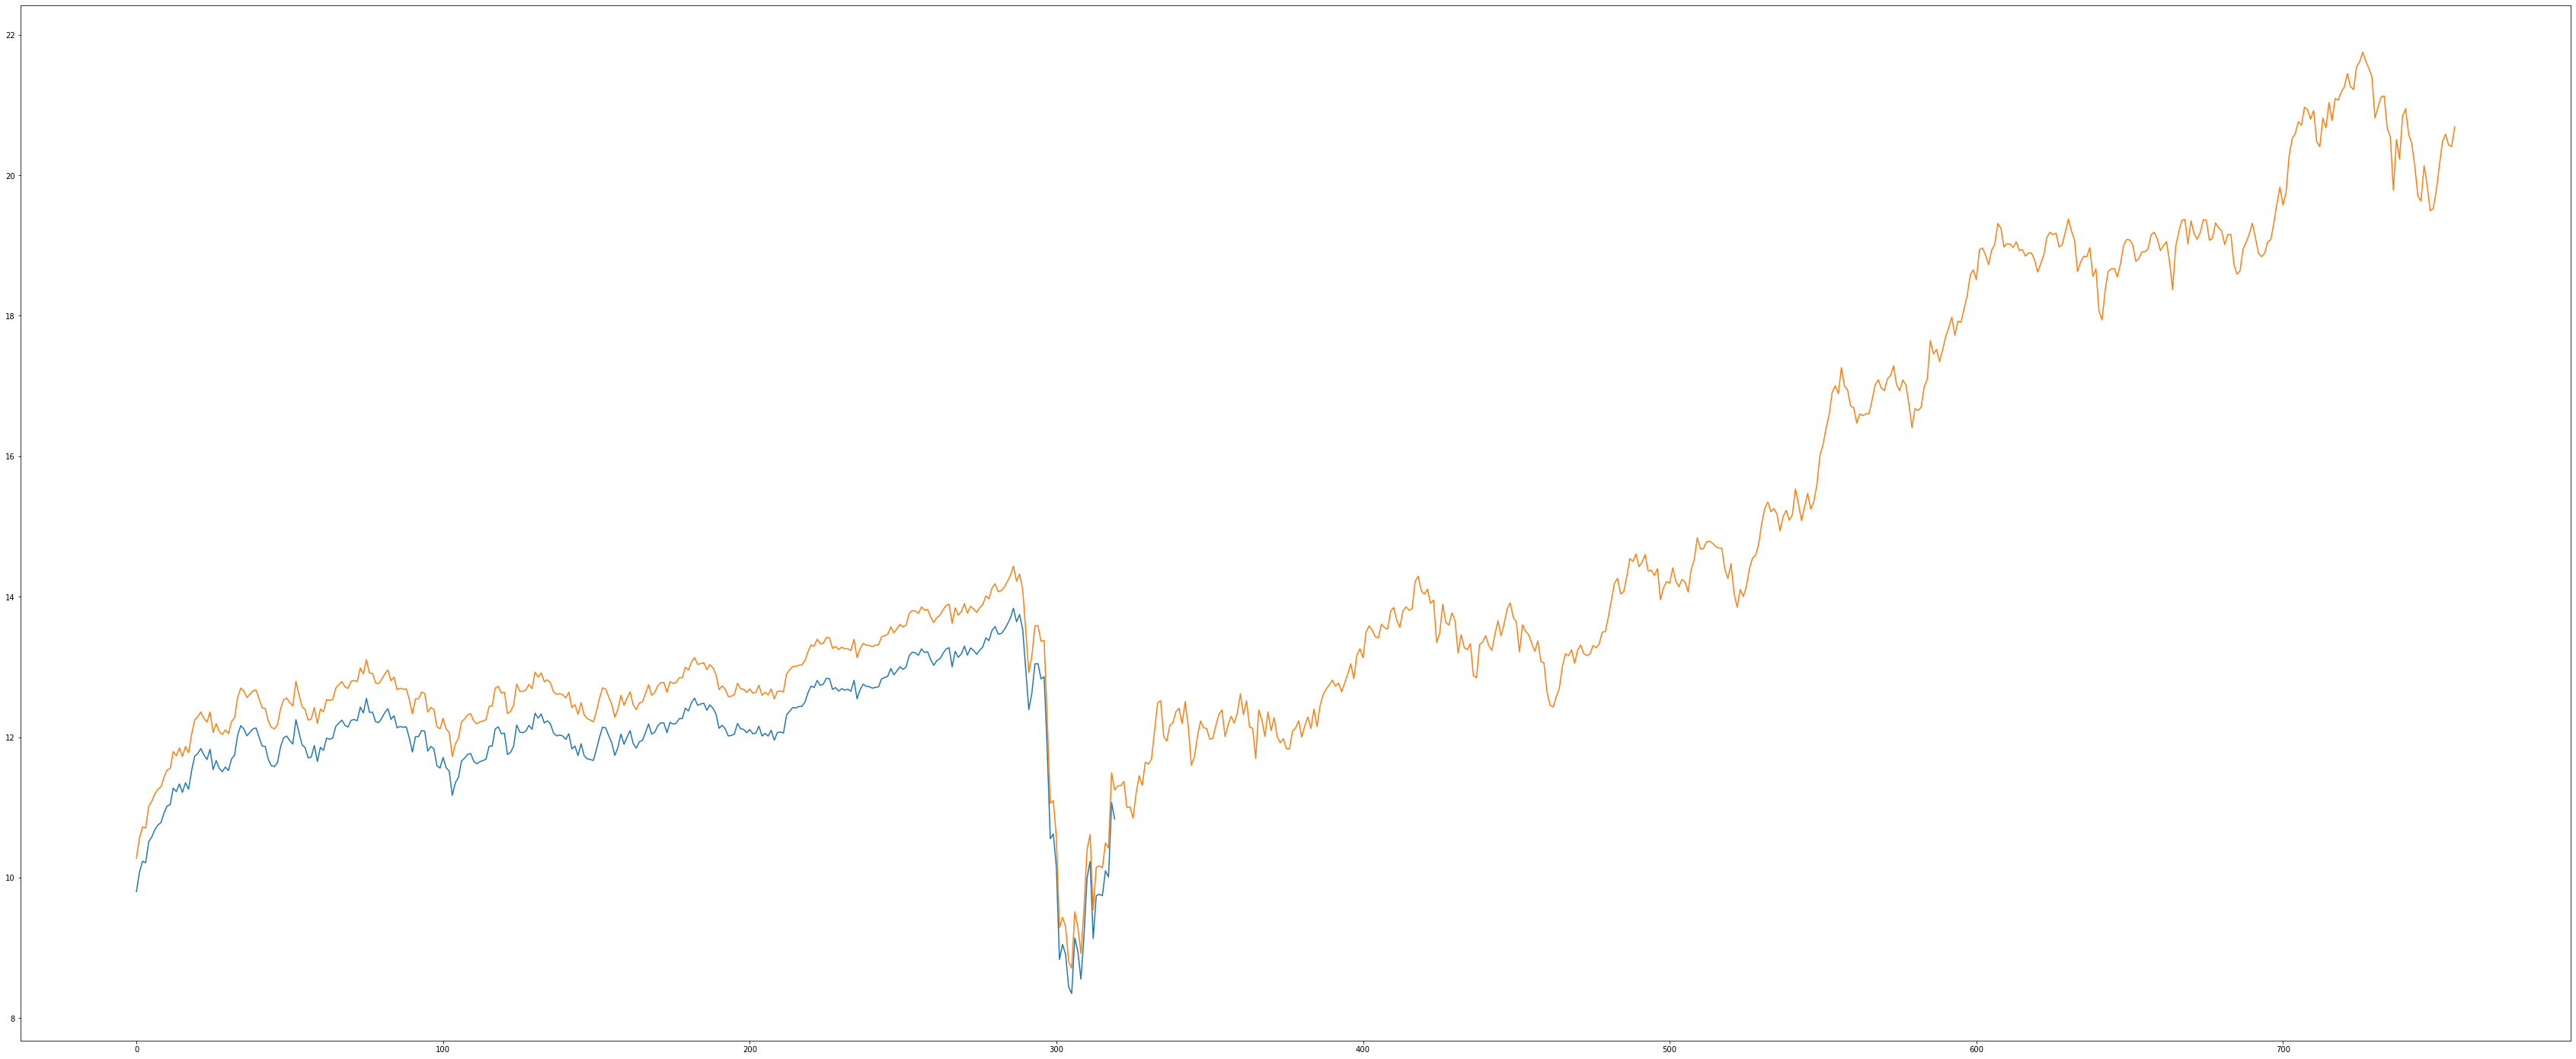

In [8]:
model_1 = least_sqaures_regression(test_replicate["EWA"] , test_replicate["EWC"])
results_1 = model_1.fit()
print(results_1.params[0])
#print(results_1.summary())

test_replicate["Plot"] = test_replicate["EWC"]  - results_1.params[0] * test_replicate["EWA"]
plt.figure(figsize=(60,25))
plt.plot(test_replicate["Plot"])
plt.plot(stationary_plot["Plot"])

print(adfuller(test_replicate["Plot"]))

Looking at the various cointegration tests, it is evident that the ratio of cointegration changes overtime. Thus we should not run our cointegration test on all the data,instead we should have a sort of rolling conintgration window. In this window we will also refine our hedge ratio. Howver, we make the notice that the hedge ratio calculated using a portion of the data and the hedge ratio computed using all of the data is pretty much the same. So this series is pretty consistent. But you may notice right now there is a major spike. We can treat this as a anomaly for now.

In [9]:
#We can also use the eigen vectors given by the Johansen test to create a balanced portfolio
#lets test if this works by comparing it to the OLS hedging values
input_data = pd.DataFrame()

input_data["EWA"] = test_replicate["EWA"]
input_data["EWC"] = test_replicate["EWC"]

print(input_data.columns)


print(input_data)

jres = johansen_test(input_data, 0 , 1)

trstat = jres.lr1                       # trace statistic
tsignf = jres.cvt                       # critical values
eigen_vec = jres.evec
eigen_vals = jres.eig                  

print("trace statistics", trstat)
print("critical values", tsignf)
print("Eigen vectors:", eigen_vec)
print("Eigen vals",eigen_vals)
print(eigen_vec[:,0])

Index(['EWA', 'EWC'], dtype='object')
           EWA        EWC
0    16.816011  22.219603
1    16.994621  22.632469
2    17.208949  22.942117
3    17.467932  23.111013
4    17.735846  23.608330
..         ...        ...
315  13.992841  20.075175
316  13.964949  20.411038
317  14.513506  20.727711
318  14.950491  22.109561
319  14.606480  21.620156

[320 rows x 2 columns]
trace statistics [1.57732834e+01 9.26921680e-06]
critical values [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Eigen vectors: [[ 2.68227493 -1.40388168]
 [-2.3454686   0.6990438 ]]
Eigen vals [4.83914264e-02 2.91484801e-08]
[ 2.68227493 -2.3454686 ]


Plot1 (-3.5216586054227776, 0.007447969162170781, 7, 312, {'1%': -3.4514843502727306, '5%': -2.8708485956333556, '10%': -2.571729625657462}, -92.35256353492491)
Plot2 (-3.2776002609278496, 0.015909920483778782, 12, 307, {'1%': -3.4518314994261337, '5%': -2.8710009653519166, '10%': -2.571810878948318}, -128.6484075587889)


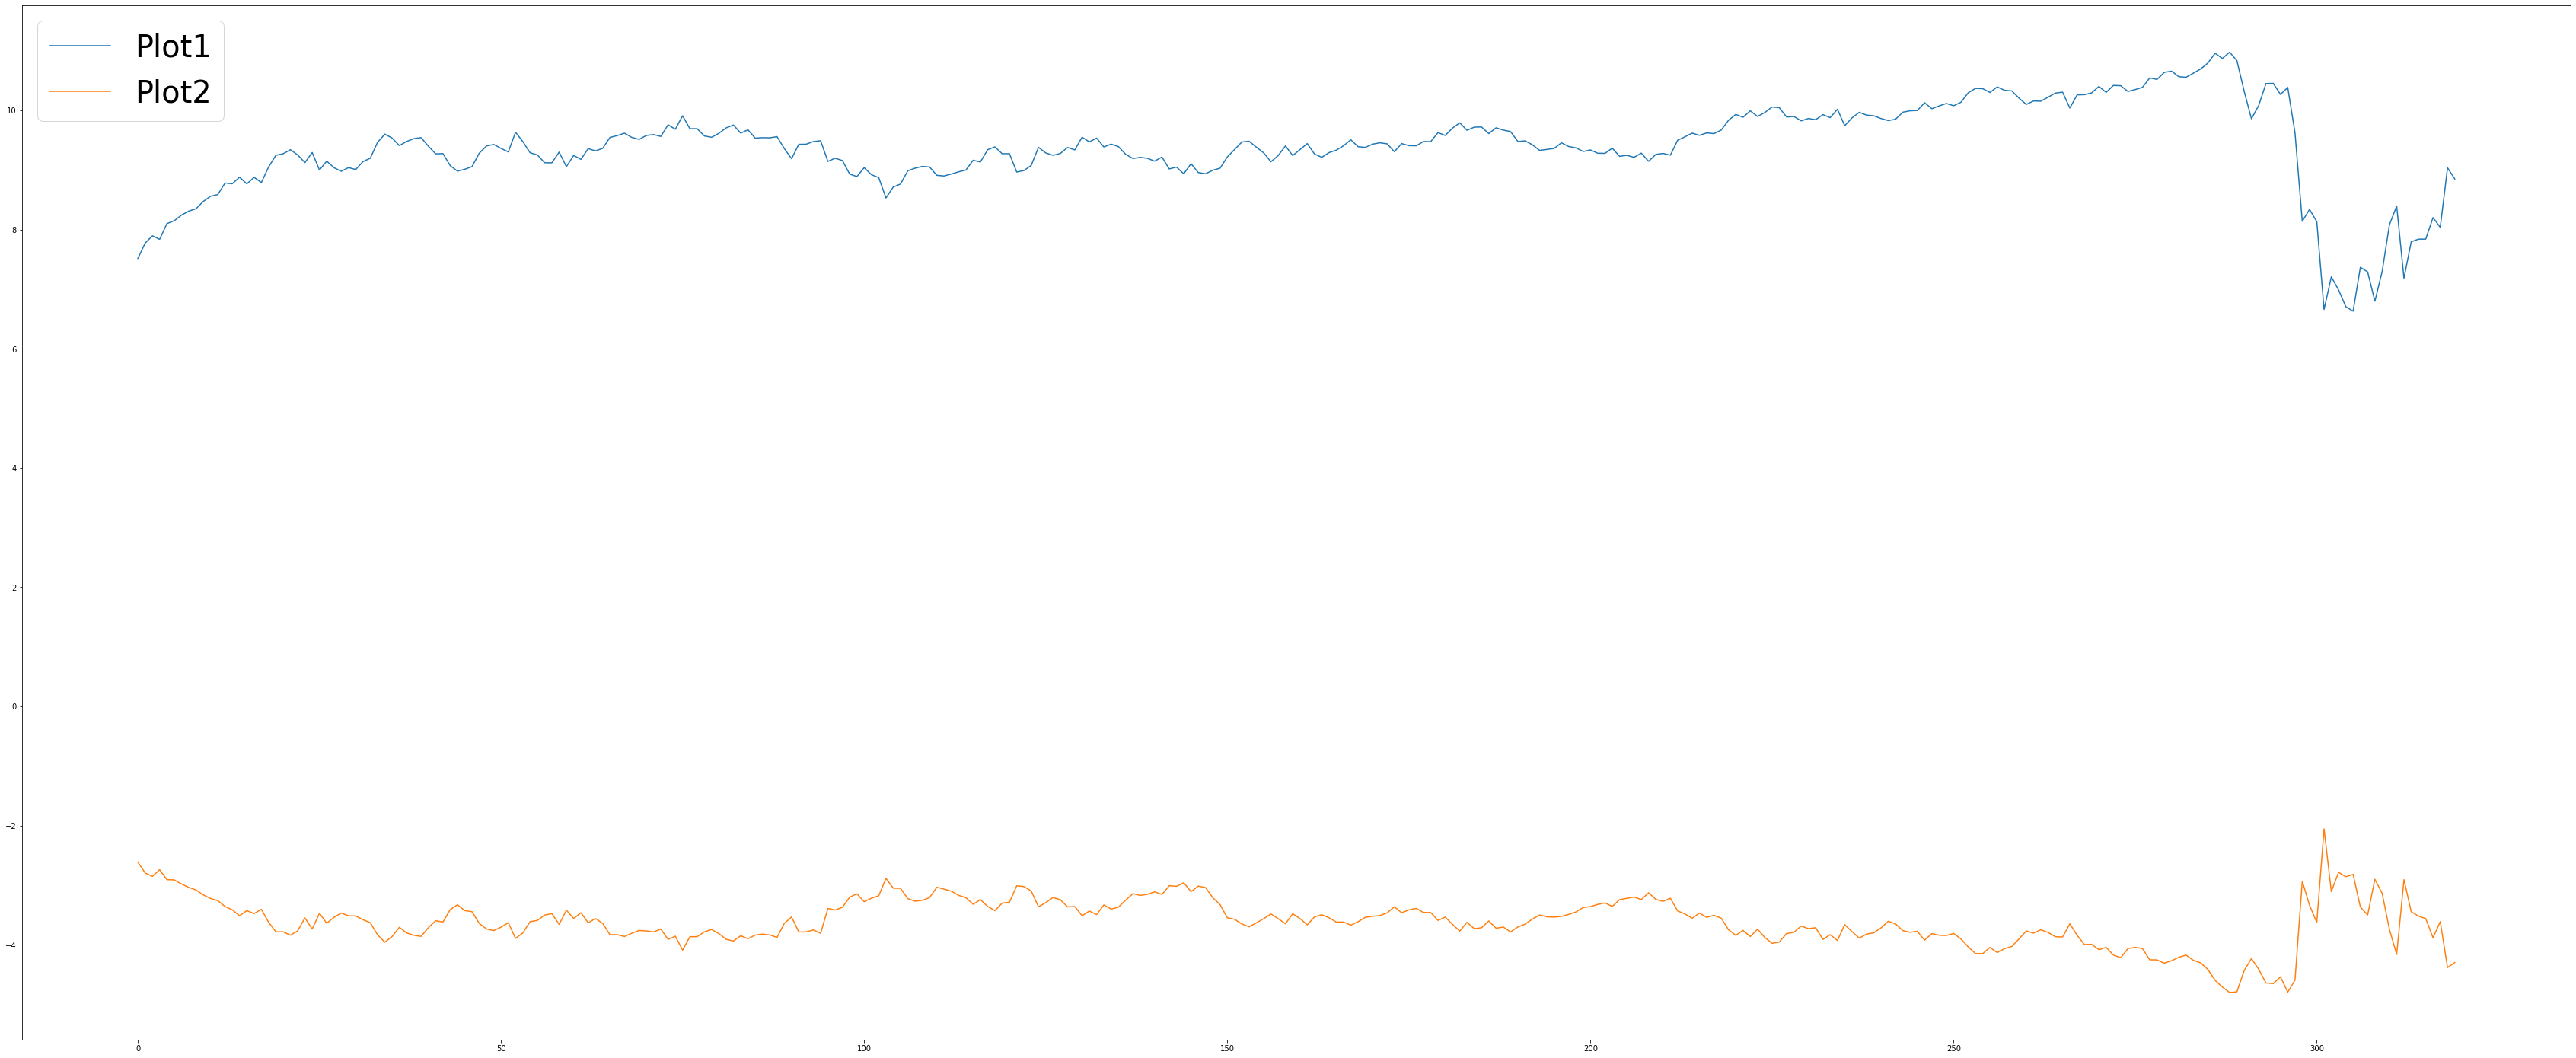

In [10]:

test_replicate["Plot1"] = (eigen_vec[:,0][0]/eigen_vec[:,0][0]) * test_replicate["EWC"]  + (eigen_vec[:,0][1]/eigen_vec[:,0][0]) * test_replicate["EWA"]
test_replicate["Plot2"] = (eigen_vec[:,0][0]/eigen_vec[:,0][0]) * test_replicate["EWA"]  + (eigen_vec[:,0][1]/eigen_vec[:,0][0]) * test_replicate["EWC"]

plt.figure(figsize=(60,25))
plt.plot(test_replicate["Plot1"], label = "Plot1")
plt.plot(test_replicate["Plot2"], label = "Plot2")
plt.legend(loc="upper left", prop={'size': 40})


print("Plot1",adfuller(test_replicate["Plot1"]))
print("Plot2",adfuller(test_replicate["Plot2"]))


#this shows us the eigen values of the johasen test are in the order to create of the columns in the dataframe as plot two gives a better result for cointegration


From this experiment, I noted how to read the results the johansen test from the stats models library. Notice, that when reading the output matrix, you should read it as a matrix, not a list of lists. So the first eigen vector would be the first column, not the row. Also, if we want to know which eigen vector value corresponds to which time series, we need to check the order of our columns in the df. It will usually be the order we added them, or the order we declared them. You can check by either outputing the time series, or just outputiting the columns. One odd thing to note is that when we swtich the order, although the ratio (abs value) stays the same, the sign flips. 

In [11]:
#Another way to check the mean reverting-ness of a time series in the Hurst exponent test
#in general
#if H < 0.5 it is mean reverting
#if H > 0.5 it is trending
#if H = 0.5 it is a random walk
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)


    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series.values[lag:], time_series.values[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

hurst = get_hurst_exponent(test_replicate["Plot2"])
print(hurst)


0.3352039998472929


In [12]:
from statsmodels.tools.tools import add_constant
#Half life of mean reversion calculation
#y(t) - y(t-1) as the dependent variable
#y(t-1) as the independant variable


y = test_replicate["Plot2"]
y_lagged = test_replicate["Plot2"].shift(1)

dependent = y - y_lagged

y_lagged.iloc[0] = y_lagged.iloc[1]
dependent.iloc[0] = dependent.iloc[1]

model_1 = least_sqaures_regression(dependent, add_constant(y_lagged))
results_1 = model_1.fit()

print(results_1.params)

halflife = (-np.log(2)) / results_1.params[1]
print(halflife)



const   -0.552005
Plot2   -0.151715
dtype: float64
4.568749286508339


In [13]:
#Testing Moving Hedge Ratio
